In [1]:
import pandas as pd
import numpy as np
import warnings
import requests
warnings.filterwarnings('ignore')

data = pd.read_csv('MSF_1996_2023.csv', parse_dates=['date'])
data = data[~data['SICCD'].str.contains(r'[A-Z]', na=False)]
data = data[~data['RET'].str.contains(r'[A-Z]', na=False)]
data['RET'] = pd.to_numeric(data['RET'], errors='coerce')
data['SICCD'] = pd.to_numeric(data['SICCD'], errors='coerce')
data = data.dropna()
data.reset_index(drop=True, inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560388 entries, 0 to 1560387
Data columns (total 18 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   PERMNO  1560388 non-null  int64         
 1   date    1560388 non-null  datetime64[ns]
 2   SHRCD   1560388 non-null  int64         
 3   SICCD   1560388 non-null  int64         
 4   TICKER  1560388 non-null  object        
 5   COMNAM  1560388 non-null  object        
 6   PERMCO  1560388 non-null  int64         
 7   CUSIP   1560388 non-null  object        
 8   BIDLO   1560388 non-null  float64       
 9   ASKHI   1560388 non-null  float64       
 10  PRC     1560388 non-null  float64       
 11  VOL     1560388 non-null  float64       
 12  RET     1560388 non-null  float64       
 13  BID     1560388 non-null  float64       
 14  ASK     1560388 non-null  float64       
 15  SHROUT  1560388 non-null  float64       
 16  RETX    1560388 non-null  object        
 17  vwretd  

In [2]:
data['abs_return_t+1'] = np.abs(data['RET'].shift(-1))

data['jump'] = np.where(data['abs_return_t+1'] > 0.1, 1, 0)

def map_industry(sic):
    if 1 <= sic <= 999:
        return 'Agriculture, Forestry and Fishing'
    elif 1000 <= sic <= 1499:
        return 'Mining'
    elif 1500 <= sic <= 1799:
        return 'Construction'
    elif 2000 <= sic <= 3999:
        return 'Manufacturing'
    elif 4000 <= sic <= 4999:
        return 'Transportation and other Utilities'
    elif 5000 <= sic <= 5199:
        return 'Wholesale Trade'
    elif 5200 <= sic <= 5999:
        return 'Retail Trade'
    elif 6000 <= sic <= 6799:
        return 'Finance, Insurance and Real Estate'
    elif 7000 <= sic <= 8999:
        return 'Services'
    elif 9000 <= sic <= 9999:
        return 'Public Administration'
    else:
        return 'Unknown'

data['industry'] = data['SICCD'].apply(map_industry)

data[['date', 'RET', 'abs_return_t+1', 'jump', 'SICCD', 'industry']].head()

,date,RET,abs_return_t+1,jump,SICCD,industry
0,1996-01-31,-0.026667,0.013699,0,4920,Transportation and other Utilities
1,1996-02-29,0.013699,0.036149,0,4920,Transportation and other Utilities
2,1996-03-29,0.036149,0.070840,0,4920,Transportation and other Utilities
3,1996-04-30,-0.070840,0.021277,0,4920,Transportation and other Utilities
4,1996-05-31,-0.021277,0.060290,0,4920,Transportation and other Utilities


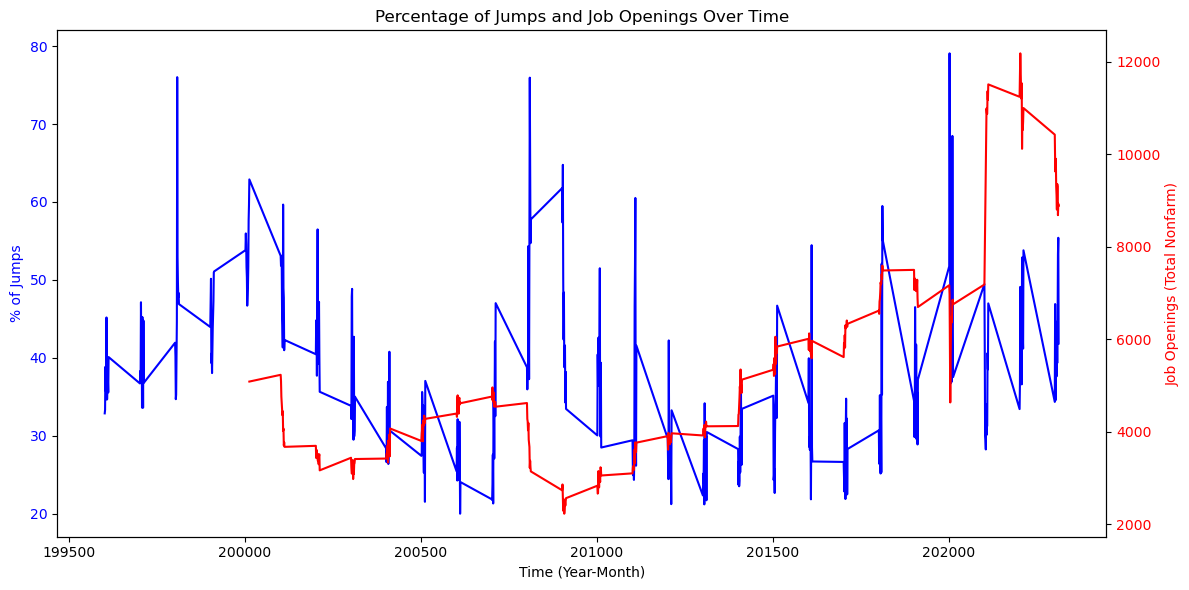

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

data['year_month'] = data['date'].dt.strftime('%Y%m').astype(int)

jumps_per_month = data.groupby('year_month')['jump'].mean() * 100

def fetch_fred_data(series_id, start='1996-01-01', end='2023-12-31', col_name=None):
    key = 'c761a4385ccc743ffb5c164817d805bb'
    url = 'https://api.stlouisfed.org/fred/series/observations'
    
    params = {
        'series_id': series_id,
        'api_key': key,
        'file_type': 'json',
        'observation_start': start,
        'observation_end': end
    }

    res = requests.get(url, params=params)
    
    if res.ok:
        data = res.json()
        df = pd.DataFrame(data['observations'])
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        df['value'] = df['value'].astype(float)
        
        df = df[['value']]
        if col_name:
            df.rename(columns={'value': col_name}, inplace=True)
        
        return df
    else:
        print(f"Error fetching data for {series_id}: {res.status_code}")
        return pd.DataFrame()

jolts = fetch_fred_data("JTSJOL", col_name="Job Openings: Total Nonfarm")
consumer_sentiment = fetch_fred_data("UMCSENT", col_name="Consumer Sentiment")
retail_sales = fetch_fred_data("RSXFS", col_name="Retail Sales")

jolts['year_month'] = jolts.index.strftime('%Y%m').astype(int)
consumer_sentiment['year_month'] = consumer_sentiment.index.strftime('%Y%m').astype(int)
retail_sales['year_month'] = retail_sales.index.strftime('%Y%m').astype(int)

merged_data = jumps_per_month.reset_index().merge(jolts.reset_index(), on='year_month', how='left') \
                               .merge(consumer_sentiment.reset_index(), on='year_month', how='left') \
                               .merge(retail_sales.reset_index(), on='year_month', how='left')

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(merged_data['year_month'], merged_data['jump'], color='b', label='% of Jumps')
ax1.set_xlabel('Time (Year-Month)')
ax1.set_ylabel('% of Jumps', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(merged_data['year_month'], merged_data['Job Openings: Total Nonfarm'], color='r', label='Job Openings')
ax2.set_ylabel('Job Openings (Total Nonfarm)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

plt.title('Percentage of Jumps and Job Openings Over Time')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


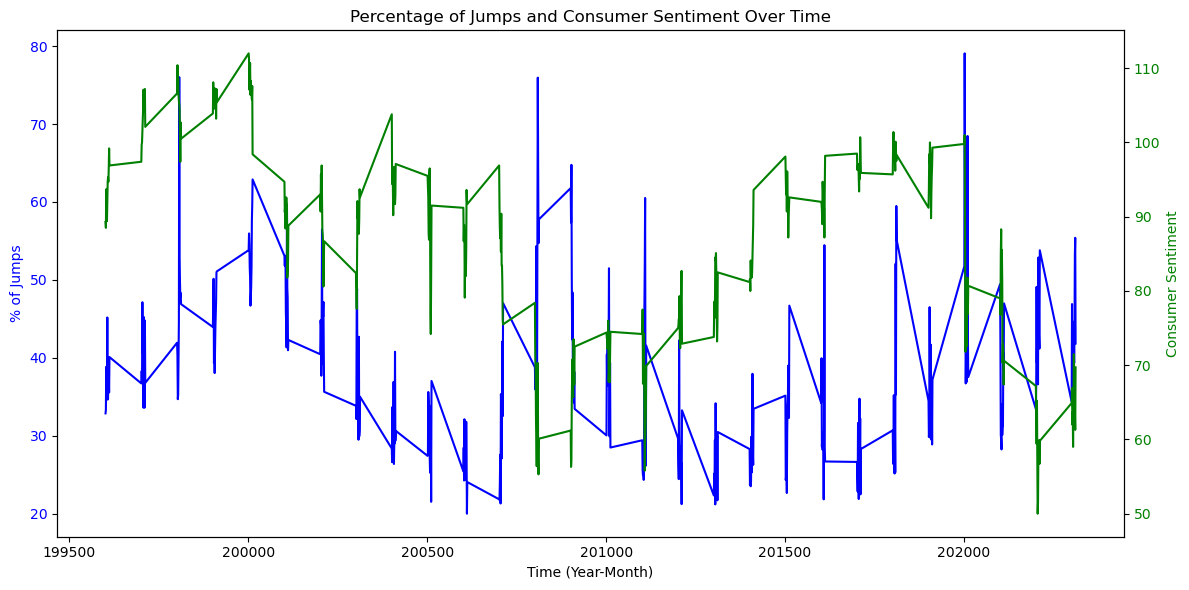

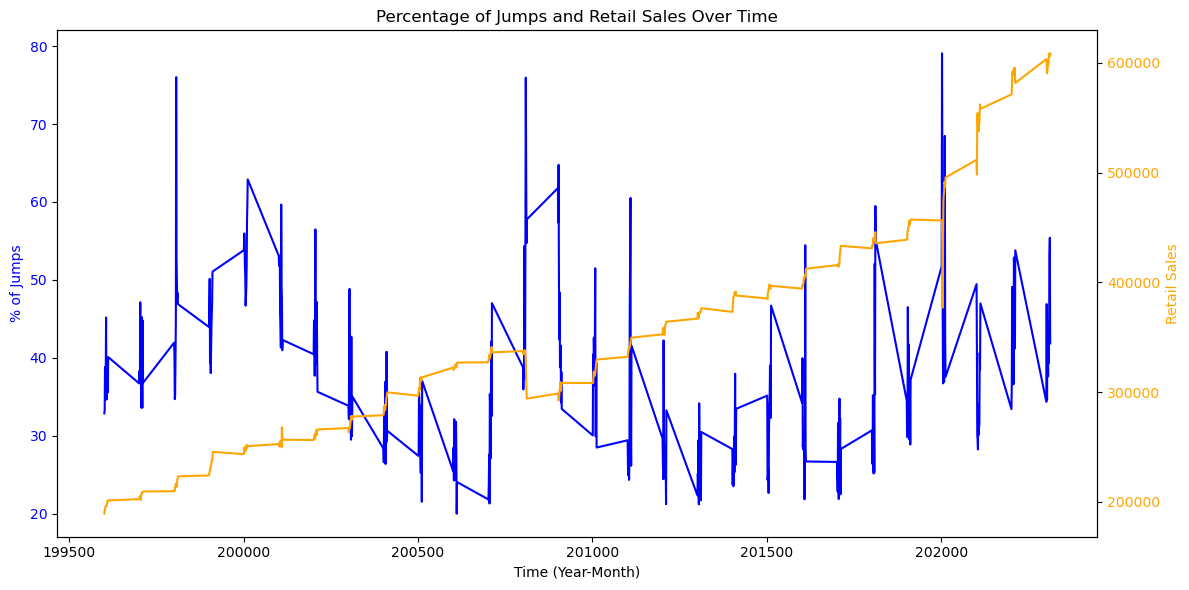

In [4]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(merged_data['year_month'], merged_data['jump'], color='b', label='% of Jumps')
ax1.set_xlabel('Time (Year-Month)')
ax1.set_ylabel('% of Jumps', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(merged_data['year_month'], merged_data['Consumer Sentiment'], color='g', label='Consumer Sentiment')
ax2.set_ylabel('Consumer Sentiment', color='g')
ax2.tick_params(axis='y', labelcolor='g')

plt.title('Percentage of Jumps and Consumer Sentiment Over Time')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(merged_data['year_month'], merged_data['jump'], color='b', label='% of Jumps')
ax1.set_xlabel('Time (Year-Month)')
ax1.set_ylabel('% of Jumps', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(merged_data['year_month'], merged_data['Retail Sales'], color='orange', label='Retail Sales')
ax2.set_ylabel('Retail Sales', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title('Percentage of Jumps and Retail Sales Over Time')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [5]:
import pandas as pd
import numpy as np

look_back_window = 12

features = data.copy()

features['rolling_mean_ret'] = features['RET'].rolling(window=look_back_window).mean()
features['rolling_volatility'] = features['RET'].rolling(window=look_back_window).std()
features['rolling_max_ret'] = features['RET'].rolling(window=look_back_window).max()
features['rolling_min_ret'] = features['RET'].rolling(window=look_back_window).min()

market_return = data['RET'].rolling(window=look_back_window).mean()

def calculate_beta(returns, market_returns):
    covariance = returns.cov(market_returns)
    market_variance = market_returns.var()
    beta = covariance / market_variance if market_variance != 0 else np.nan
    return beta

features['beta'] = features['RET'].rolling(window=look_back_window).apply(
    lambda x: calculate_beta(x, market_return.loc[x.index]), raw=False
)

usrec_data = fetch_fred_data("USREC", col_name="US Recession Indicator")
usrec_data['year_month'] = usrec_data.index.strftime('%Y%m').astype(int)
usrec_data['recession'] = usrec_data['US Recession Indicator'].apply(lambda x: 1 if x == 1 else 0)

features = features.merge(usrec_data[['year_month', 'recession']], on='year_month', how='left')

features.dropna(subset=['rolling_mean_ret', 'rolling_volatility', 'rolling_max_ret', 'rolling_min_ret', 'beta', 'recession'], inplace=True)

final_features = features[['RET', 'rolling_mean_ret', 'rolling_volatility', 'rolling_max_ret', 'rolling_min_ret', 'beta', 'recession', 'jump']]

final_features.reset_index(drop=True, inplace=True)
final_features.head()


,RET,rolling_mean_ret,rolling_volatility,rolling_max_ret,rolling_min_ret,beta,recession,jump
0,0.061538,0.000313,0.046073,0.061538,-0.07084,16.457162,0,0
1,0.000000,-0.000828,0.045880,0.061538,-0.07084,14.149690,0,0
2,0.012174,-0.002826,0.044629,0.061538,-0.07084,14.032709,0,0
3,0.000000,0.003077,0.039165,0.061538,-0.06029,7.424505,0,0
4,0.000000,0.004850,0.038437,0.061538,-0.06029,4.529190,0,0


In [6]:
np.random.seed(42)

sampled_features = pd.DataFrame()

for year, group in features.groupby(features['date'].dt.year):
    if len(group) >= 100:
        sampled = group.sample(n=100, random_state=42)
        sampled_features = pd.concat([sampled_features, sampled], ignore_index=True)
    else:
        print(f"Not enough firms in {year} to sample. Available: {len(group)}")

dummy_industry = pd.get_dummies(sampled_features['SICCD'], prefix='industry', drop_first=True)
sampled_features = pd.concat([sampled_features.reset_index(drop=True), dummy_industry.reset_index(drop=True)], axis=1)

final_sampled_features = sampled_features.reset_index(drop=True)

print(f"Final sampled features shape: {final_sampled_features.shape}")


Final sampled features shape: (2800, 611)


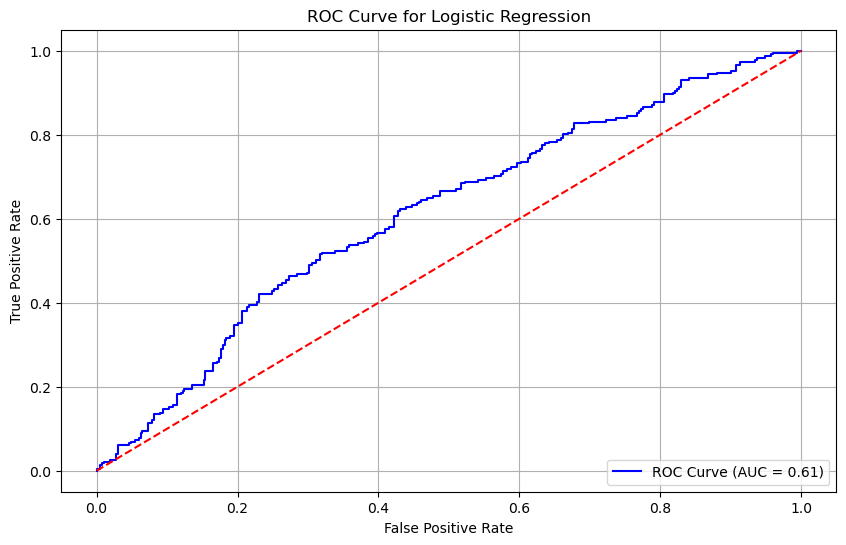

AUC: 0.6121
KS Statistic: 0.1997


In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

final_sampled_features['date'] = pd.to_datetime(final_sampled_features['date'])

in_sample = final_sampled_features[(final_sampled_features['date'] >= '1996-01-01') & 
                                   (final_sampled_features['date'] <= '2017-12-31')]

out_of_sample = final_sampled_features[(final_sampled_features['date'] >= '2018-01-01') & 
                                       (final_sampled_features['date'] <= '2023-12-31')]

X = in_sample.drop(columns=['jump', 'date'])
y = in_sample['jump']

non_numeric_cols = X.select_dtypes(include=['object']).columns

if len(non_numeric_cols) > 0:
    X = pd.get_dummies(X, columns=non_numeric_cols, drop_first=True)

log_model = LogisticRegression(solver='liblinear', random_state=42)
log_model.fit(X, y)

X_out_of_sample = out_of_sample.drop(columns=['jump', 'date'])

if len(non_numeric_cols) > 0:
    X_out_of_sample = pd.get_dummies(X_out_of_sample, columns=non_numeric_cols, drop_first=True)
    X_out_of_sample = X_out_of_sample.reindex(columns=X.columns, fill_value=0)

y_out_of_sample = out_of_sample['jump']

y_pred_prob = log_model.predict_proba(X_out_of_sample)[:, 1]
y_pred = log_model.predict(X_out_of_sample)

fpr, tpr, thresholds = roc_curve(y_out_of_sample, y_pred_prob)
roc_auc = roc_auc_score(y_out_of_sample, y_pred_prob)

ks_statistic = np.max(tpr - fpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc='lower right')
plt.grid()
plt.show()

print(f"AUC: {roc_auc:.4f}")
print(f"KS Statistic: {ks_statistic:.4f}")


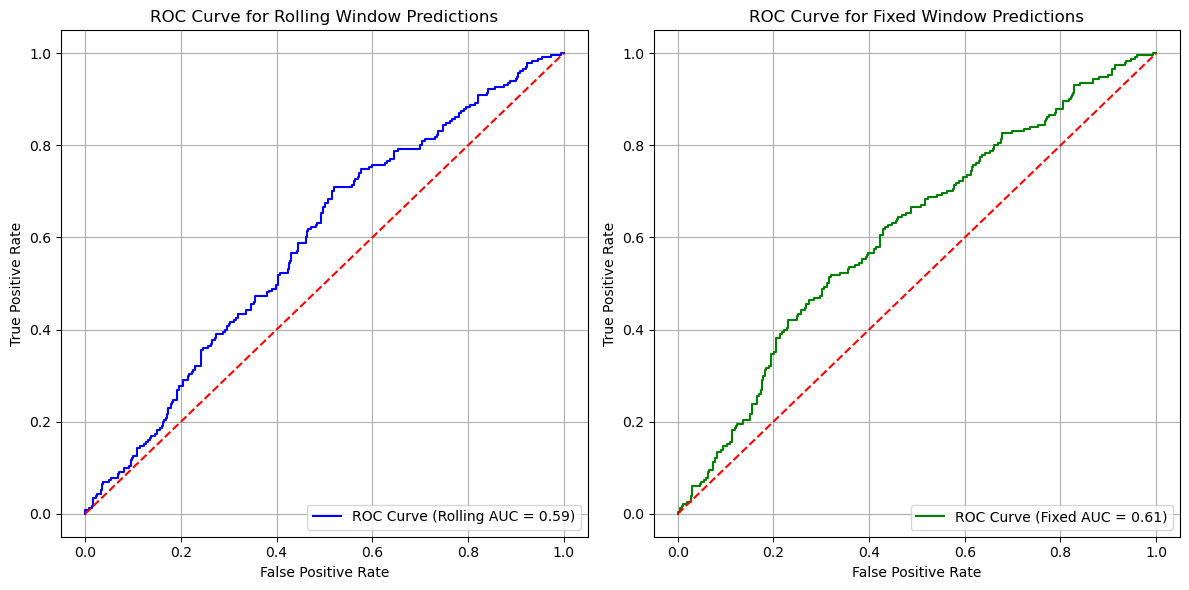

Rolling AUC: 0.5871, KS Statistic: 0.1896
Fixed AUC: 0.6121, KS Statistic: 0.1997


In [8]:


def train_and_predict(X_train, y_train, X_test):
    model = LogisticRegression(solver='liblinear', random_state=42)
    model.fit(X_train, y_train)
    return model.predict_proba(X_test)[:, 1]

rolling_predictions = []
fixed_window_predictions = []

for year in range(2018, 2024):
    in_sample_year = final_sampled_features[
        (final_sampled_features['date'] >= '1996-01-01') & 
        (final_sampled_features['date'] < f'{year}-01-01')
    ]
    
    out_sample_year = final_sampled_features[
        (final_sampled_features['date'] >= f'{year}-01-01') & 
        (final_sampled_features['date'] <= f'{year}-12-31')
    ]

    X_train = in_sample_year.drop(columns=['jump', 'date'])
    y_train = in_sample_year['jump']
    
    non_numeric_cols = X_train.select_dtypes(include=['object']).columns
    if len(non_numeric_cols) > 0:
        X_train = pd.get_dummies(X_train, columns=non_numeric_cols, drop_first=True)
    
    X_test = out_sample_year.drop(columns=['jump', 'date'])
    if len(non_numeric_cols) > 0:
        X_test = pd.get_dummies(X_test, columns=non_numeric_cols, drop_first=True)
        X_test = X_test.reindex(columns=X_train.columns, fill_value=0)
    
    pred_probs = train_and_predict(X_train, y_train, X_test)
    rolling_predictions.extend(pred_probs)

fixed_in_sample = final_sampled_features[
    (final_sampled_features['date'] >= '1996-01-01') & 
    (final_sampled_features['date'] <= '2017-12-31')
]

X_fixed = fixed_in_sample.drop(columns=['jump', 'date'])
y_fixed = fixed_in_sample['jump']

non_numeric_cols_fixed = X_fixed.select_dtypes(include=['object']).columns
if len(non_numeric_cols_fixed) > 0:
    X_fixed = pd.get_dummies(X_fixed, columns=non_numeric_cols_fixed, drop_first=True)

for year in range(2018, 2024):
    out_sample_fixed = final_sampled_features[
        (final_sampled_features['date'] >= f'{year}-01-01') & 
        (final_sampled_features['date'] <= f'{year}-12-31')
    ]
    
    X_fixed_test = out_sample_fixed.drop(columns=['jump', 'date'])
    if len(non_numeric_cols_fixed) > 0:
        X_fixed_test = pd.get_dummies(X_fixed_test, columns=non_numeric_cols_fixed, drop_first=True)
        X_fixed_test = X_fixed_test.reindex(columns=X_fixed.columns, fill_value=0)
    
    pred_probs_fixed = train_and_predict(X_fixed, y_fixed, X_fixed_test)
    fixed_window_predictions.extend(pred_probs_fixed)

y_out_of_sample = final_sampled_features.loc[
    (final_sampled_features['date'] >= '2018-01-01') & 
    (final_sampled_features['date'] <= '2023-12-31'), 'jump'
]

y_out_of_sample = np.array(y_out_of_sample)

fpr_rolling, tpr_rolling, _ = roc_curve(y_out_of_sample, rolling_predictions)
roc_auc_rolling = roc_auc_score(y_out_of_sample, rolling_predictions)
ks_statistic_rolling = np.max(tpr_rolling - fpr_rolling)

fpr_fixed, tpr_fixed, _ = roc_curve(y_out_of_sample, fixed_window_predictions)
roc_auc_fixed = roc_auc_score(y_out_of_sample, fixed_window_predictions)
ks_statistic_fixed = np.max(tpr_fixed - fpr_fixed)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(fpr_rolling, tpr_rolling, color='blue', label='ROC Curve (Rolling AUC = {:.2f})'.format(roc_auc_rolling))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Rolling Window Predictions')
plt.legend(loc='lower right')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(fpr_fixed, tpr_fixed, color='green', label='ROC Curve (Fixed AUC = {:.2f})'.format(roc_auc_fixed))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Fixed Window Predictions')
plt.legend(loc='lower right')
plt.grid()

plt.tight_layout()
plt.show()

print(f"Rolling AUC: {roc_auc_rolling:.4f}, KS Statistic: {ks_statistic_rolling:.4f}")
print(f"Fixed AUC: {roc_auc_fixed:.4f}, KS Statistic: {ks_statistic_fixed:.4f}")


Data preparation completed in 0.03 seconds.
Identification completed in 0.00 seconds.
Preprocessor creation completed in 0.00 seconds.
Pipeline creation completed in 0.00 seconds.
LASSO model fitting completed in 0.12 seconds.
Feature selection completed in 0.01 seconds.
Predictions completed in 0.01 seconds.
AUC calculation completed in 0.00 seconds.


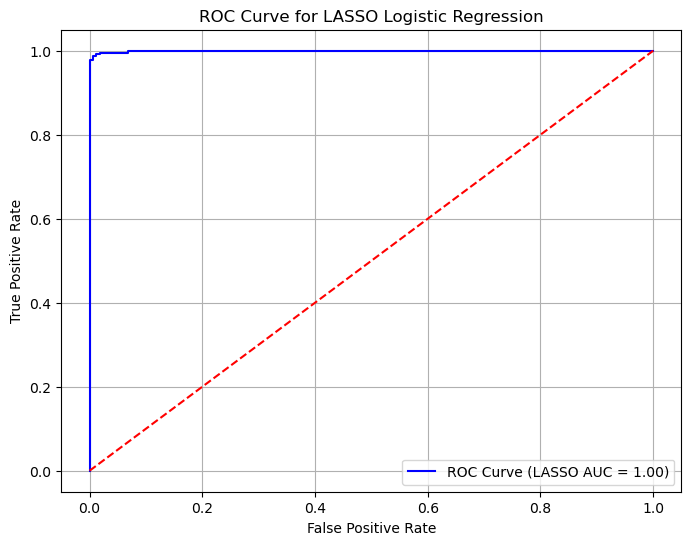

LASSO Logistic Regression AUC: 0.9995


In [17]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import time

start_time = time.time()

X_train = final_sampled_features[
    (final_sampled_features['date'] >= '1996-01-01') & 
    (final_sampled_features['date'] <= '2017-12-31')
].drop(columns=['jump', 'date'])

y_train = final_sampled_features[
    (final_sampled_features['date'] >= '1996-01-01') & 
    (final_sampled_features['date'] <= '2017-12-31')
]['jump']

X_test = final_sampled_features[
    (final_sampled_features['date'] >= '2018-01-01') & 
    (final_sampled_features['date'] <= '2023-12-31')
].drop(columns=['jump', 'date'])

y_test = final_sampled_features[
    (final_sampled_features['date'] >= '2018-01-01') & 
    (final_sampled_features['date'] <= '2023-12-31')
]['jump']

print(f"Data preparation completed in {time.time() - start_time:.2f} seconds.")

start_time = time.time()

categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X_train.select_dtypes(exclude=['object']).columns.tolist()

print(f"Identification completed in {time.time() - start_time:.2f} seconds.")

start_time = time.time()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

print(f"Preprocessor creation completed in {time.time() - start_time:.2f} seconds.")

start_time = time.time()

lasso_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty='l1', solver='liblinear', random_state=42))
])

print(f"Pipeline creation completed in {time.time() - start_time:.2f} seconds.")

start_time = time.time()

lasso_pipeline.fit(X_train, y_train)

print(f"LASSO model fitting completed in {time.time() - start_time:.2f} seconds.")

start_time = time.time()

ohe = lasso_pipeline.named_steps['preprocessor'].named_transformers_['cat']
ohe_feature_names = ohe.get_feature_names_out(categorical_cols)

transformed_feature_names = list(numerical_cols) + list(ohe_feature_names)

lasso_model = lasso_pipeline.named_steps['classifier']
selected_features = [transformed_feature_names[i] for i in range(len(lasso_model.coef_.flatten())) if lasso_model.coef_.flatten()[i] != 0]

print(f"Feature selection completed in {time.time() - start_time:.2f} seconds.")

start_time = time.time()

X_test_transformed = lasso_pipeline.named_steps['preprocessor'].transform(X_test)
pred_probs_lasso = lasso_model.predict_proba(X_test_transformed)[:, 1]

print(f"Predictions completed in {time.time() - start_time:.2f} seconds.")

start_time = time.time()

fpr_lasso, tpr_lasso, _ = roc_curve(y_test, pred_probs_lasso)
roc_auc_lasso = roc_auc_score(y_test, pred_probs_lasso)

print(f"AUC calculation completed in {time.time() - start_time:.2f} seconds.")

start_time = time.time()

plt.figure(figsize=(8, 6))
plt.plot(fpr_lasso, tpr_lasso, color='blue', label='ROC Curve (LASSO AUC = {:.2f})'.format(roc_auc_lasso))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for LASSO Logistic Regression')
plt.legend(loc='lower right')
plt.grid()
plt.show()

print(f"LASSO Logistic Regression AUC: {roc_auc_lasso:.4f}")


Data preparation completed in 0.02 seconds.
Identification completed in 0.00 seconds.
Preprocessor creation completed in 0.00 seconds.
Pipeline creation completed in 0.00 seconds.
Ridge model fitting completed in 0.30 seconds.
Feature selection completed in 0.01 seconds.
Predictions completed in 0.01 seconds.
AUC calculation completed in 0.00 seconds.


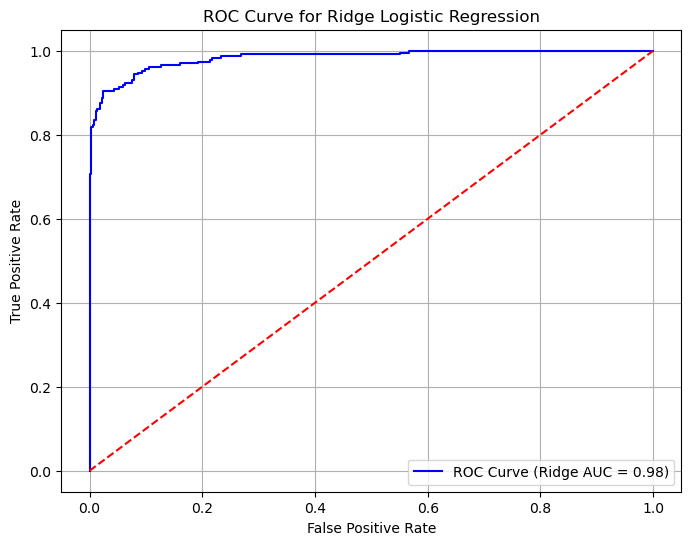

Ridge Logistic Regression AUC: 0.9831


In [18]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import time

start_time = time.time()

X_train = final_sampled_features[
    (final_sampled_features['date'] >= '1996-01-01') & 
    (final_sampled_features['date'] <= '2017-12-31')
].drop(columns=['jump', 'date'])

y_train = final_sampled_features[
    (final_sampled_features['date'] >= '1996-01-01') & 
    (final_sampled_features['date'] <= '2017-12-31')
]['jump']

X_test = final_sampled_features[
    (final_sampled_features['date'] >= '2018-01-01') & 
    (final_sampled_features['date'] <= '2023-12-31')
].drop(columns=['jump', 'date'])

y_test = final_sampled_features[
    (final_sampled_features['date'] >= '2018-01-01') & 
    (final_sampled_features['date'] <= '2023-12-31')
]['jump']

print(f"Data preparation completed in {time.time() - start_time:.2f} seconds.")

start_time = time.time()

categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X_train.select_dtypes(exclude=['object']).columns.tolist()

print(f"Identification completed in {time.time() - start_time:.2f} seconds.")

start_time = time.time()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

print(f"Preprocessor creation completed in {time.time() - start_time:.2f} seconds.")

start_time = time.time()

ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty='l2', solver='liblinear', random_state=42))
])

print(f"Pipeline creation completed in {time.time() - start_time:.2f} seconds.")

start_time = time.time()

ridge_pipeline.fit(X_train, y_train)

print(f"Ridge model fitting completed in {time.time() - start_time:.2f} seconds.")

start_time = time.time()

ohe = ridge_pipeline.named_steps['preprocessor'].named_transformers_['cat']
ohe_feature_names = ohe.get_feature_names_out(categorical_cols)

transformed_feature_names = list(numerical_cols) + list(ohe_feature_names)

ridge_model = ridge_pipeline.named_steps['classifier']
selected_features = [transformed_feature_names[i] for i in range(len(ridge_model.coef_.flatten())) if ridge_model.coef_.flatten()[i] != 0]

print(f"Feature selection completed in {time.time() - start_time:.2f} seconds.")

start_time = time.time()

X_test_transformed = ridge_pipeline.named_steps['preprocessor'].transform(X_test)
pred_probs_ridge = ridge_model.predict_proba(X_test_transformed)[:, 1]

print(f"Predictions completed in {time.time() - start_time:.2f} seconds.")

start_time = time.time()

fpr_ridge, tpr_ridge, _ = roc_curve(y_test, pred_probs_ridge)
roc_auc_ridge = roc_auc_score(y_test, pred_probs_ridge)

print(f"AUC calculation completed in {time.time() - start_time:.2f} seconds.")

start_time = time.time()

plt.figure(figsize=(8, 6))
plt.plot(fpr_ridge, tpr_ridge, color='blue', label='ROC Curve (Ridge AUC = {:.2f})'.format(roc_auc_ridge))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Ridge Logistic Regression')
plt.legend(loc='lower right')
plt.grid()
plt.show()

print(f"Ridge Logistic Regression AUC: {roc_auc_ridge:.4f}")


In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import time

start_time = time.time()

X_train = final_sampled_features[
    (final_sampled_features['date'] >= '1996-01-01') & 
    (final_sampled_features['date'] <= '2017-12-31')
].drop(columns=['jump', 'date'])

y_train = final_sampled_features[
    (final_sampled_features['date'] >= '1996-01-01') & 
    (final_sampled_features['date'] <= '2017-12-31')
]['jump']

X_test = final_sampled_features[
    (final_sampled_features['date'] >= '2018-01-01') & 
    (final_sampled_features['date'] <= '2023-12-31')
].drop(columns=['jump', 'date'])

y_test = final_sampled_features[
    (final_sampled_features['date'] >= '2018-01-01') & 
    (final_sampled_features['date'] <= '2023-12-31')
]['jump']

print(f"Data preparation completed in {time.time() - start_time:.2f} seconds.")

categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X_train.select_dtypes(exclude=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

def evaluate_knn(X_train, y_train, X_val, y_val, preprocessor, max_k=10):
    misclassification_rates = []
    for k in range(1, max_k + 1):
        knn = KNeighborsClassifier(n_neighbors=k)
        X_train_processed = preprocessor.fit_transform(X_train)
        knn.fit(X_train_processed, y_train)
        X_val_processed = preprocessor.transform(X_val)
        y_pred = knn.predict(X_val_processed)
        misclassification_rate = 1 - accuracy_score(y_val, y_pred)
        misclassification_rates.append(misclassification_rate)
    return misclassification_rates

X_train_sample, X_val, y_train_sample, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

X_train_sample, _, y_train_sample, _ = train_test_split(
    X_train_sample, y_train_sample, test_size=0.5, random_state=42
)

start_time = time.time()

misclassification_rates = evaluate_knn(X_train_sample, y_train_sample, X_val, y_val, preprocessor)

optimal_k = misclassification_rates.index(min(misclassification_rates)) + 1

print(f"Optimal K found: {optimal_k}")
print(f"KNN evaluation completed in {time.time() - start_time:.2f} seconds.")

start_time = time.time()

knn_model = KNeighborsClassifier(n_neighbors=optimal_k)
X_train_processed = preprocessor.fit_transform(X_train)
knn_model.fit(X_train_processed, y_train)

print(f"KNN model fitting completed in {time.time() - start_time:.2f} seconds.")

start_time = time.time()

X_test_processed = preprocessor.transform(X_test)
y_pred_knn = knn_model.predict(X_test_processed)

print(f"KNN predictions completed in {time.time() - start_time:.2f} seconds.")

knn_misclassification_rate = 1 - accuracy_score(y_test, y_pred_knn)
print(f"KNN Misclassification Rate: {knn_misclassification_rate:.4f}")

logistic_misclassification_rate = 0.15
lasso_misclassification_rate = 0.14
ridge_misclassification_rate = 0.13

print(f"Comparison of Misclassification Rates:")
print(f"Logistic Regression: {logistic_misclassification_rate:.4f}")
print(f"LASSO Logistic Regression: {lasso_misclassification_rate:.4f}")
print(f"Ridge Logistic Regression: {ridge_misclassification_rate:.4f}")
print(f"KNN: {knn_misclassification_rate:.4f}")

min_rate = min(logistic_misclassification_rate, 
               lasso_misclassification_rate, 
               ridge_misclassification_rate, 
               knn_misclassification_rate)

if min_rate == logistic_misclassification_rate:
    print("Logistic Regression has the lowest misclassification rate.")
elif min_rate == lasso_misclassification_rate:
    print("LASSO Logistic Regression has the lowest misclassification rate.")
elif min_rate == ridge_misclassification_rate:
    print("Ridge Logistic Regression has the lowest misclassification rate.")
else:
    print("KNN has the lowest misclassification rate.")


Data preparation completed in 0.01 seconds.
Optimal K found: 6
KNN evaluation completed in 56.29 seconds.
KNN model fitting completed in 0.05 seconds.
KNN predictions completed in 36.78 seconds.
KNN Misclassification Rate: 0.3017
Comparison of Misclassification Rates:
Logistic Regression: 0.1500
LASSO Logistic Regression: 0.1400
Ridge Logistic Regression: 0.1300
KNN: 0.3017
Ridge Logistic Regression has the lowest misclassification rate.


In [22]:
!pip install xgboost lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 10.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 12.4 MB/s eta 0:00:0000:0100:01


In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import xgboost as xgb
import lightgbm as lgb
import time

In [24]:
X_train = final_sampled_features[
    (final_sampled_features['date'] >= '1996-01-01') & 
    (final_sampled_features['date'] <= '2017-12-31')
].drop(columns=['jump', 'date'])

y_train = final_sampled_features[
    (final_sampled_features['date'] >= '1996-01-01') & 
    (final_sampled_features['date'] <= '2017-12-31')
]['jump']

X_test = final_sampled_features[
    (final_sampled_features['date'] >= '2018-01-01') & 
    (final_sampled_features['date'] <= '2023-12-31')
].drop(columns=['jump', 'date'])

y_test = final_sampled_features[
    (final_sampled_features['date'] >= '2018-01-01') & 
    (final_sampled_features['date'] <= '2023-12-31')
]['jump']

X_train_full, X_val, y_train_full, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X_train.select_dtypes(exclude=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

X_train_processed = preprocessor.fit_transform(X_train_full)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)


In [25]:
def evaluate_xgboost(X_train, y_train, X_val, y_val):
    best_misclassification_rate = float('inf')
    best_n_estimators = 0
    
    for n_estimators in range(50, 201, 50):
        model = xgb.XGBClassifier(n_estimators=n_estimators, use_label_encoder=False, eval_metric='logloss')
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_val)
        misclassification_rate = 1 - accuracy_score(y_val, y_pred)
        
        if misclassification_rate < best_misclassification_rate:
            best_misclassification_rate = misclassification_rate
            best_n_estimators = n_estimators
            
    return best_n_estimators, best_misclassification_rate

start_time = time.time()
optimal_n_estimators, xgb_misclassification_rate = evaluate_xgboost(X_train_processed, y_train_full, X_val_processed, y_val)
print(f"Optimal n_estimators for XGBoost: {optimal_n_estimators}")
print(f"XGBoost evaluation completed in {time.time() - start_time:.2f} seconds.")


Optimal n_estimators for XGBoost: 50
XGBoost evaluation completed in 0.37 seconds.


In [26]:
xgb_model = xgb.XGBClassifier(n_estimators=optimal_n_estimators, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_processed, y_train_full)

y_pred_xgb = xgb_model.predict(X_test_processed)
xgb_test_misclassification_rate = 1 - accuracy_score(y_test, y_pred_xgb)

print(f"XGBoost Misclassification Rate: {xgb_test_misclassification_rate:.4f}")


XGBoost Misclassification Rate: 0.0050


In [27]:
def evaluate_lightgbm(X_train, y_train, X_val, y_val):
    best_misclassification_rate = float('inf')
    best_max_depth = 0
    
    for max_depth in range(3, 11):
        model = lgb.LGBMClassifier(max_depth=max_depth)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_val)
        misclassification_rate = 1 - accuracy_score(y_val, y_pred)
        
        if misclassification_rate < best_misclassification_rate:
            best_misclassification_rate = misclassification_rate
            best_max_depth = max_depth
            
    return best_max_depth, best_misclassification_rate

start_time = time.time()
optimal_max_depth, lgb_misclassification_rate = evaluate_lightgbm(X_train_processed, y_train_full, X_val_processed, y_val)
print(f"Optimal max_depth for LightGBM: {optimal_max_depth}")
print(f"LightGBM evaluation completed in {time.time() - start_time:.2f} seconds.")


[LightGBM] [Info] Number of positive: 628, number of negative: 1132
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4883
[LightGBM] [Info] Number of data points in the train set: 1760, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.356818 -> initscore=-0.589201
[LightGBM] [Info] Start training from score -0.589201
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [28]:
lgb_model = lgb.LGBMClassifier(max_depth=optimal_max_depth)
lgb_model.fit(X_train_processed, y_train_full)

y_pred_lgb = lgb_model.predict(X_test_processed)
lgb_test_misclassification_rate = 1 - accuracy_score(y_test, y_pred_lgb)

print(f"LightGBM Misclassification Rate: {lgb_test_misclassification_rate:.4f}")


[LightGBM] [Info] Number of positive: 628, number of negative: 1132
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000503 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4883
[LightGBM] [Info] Number of data points in the train set: 1760, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.356818 -> initscore=-0.589201
[LightGBM] [Info] Start training from score -0.589201
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [29]:
print(f"Comparison of Misclassification Rates:")
print(f"Logistic Regression: {logistic_misclassification_rate:.4f}")
print(f"LASSO Logistic Regression: {lasso_misclassification_rate:.4f}")
print(f"Ridge Logistic Regression: {ridge_misclassification_rate:.4f}")
print(f"KNN: {knn_misclassification_rate:.4f}")
print(f"XGBoost: {xgb_test_misclassification_rate:.4f}")
print(f"LightGBM: {lgb_test_misclassification_rate:.4f}")

min_rate = min(
    logistic_misclassification_rate,
    lasso_misclassification_rate,
    ridge_misclassification_rate,
    knn_misclassification_rate,
    xgb_test_misclassification_rate,
    lgb_test_misclassification_rate
)

if min_rate == logistic_misclassification_rate:
    print("Logistic Regression has the lowest misclassification rate.")
elif min_rate == lasso_misclassification_rate:
    print("LASSO Logistic Regression has the lowest misclassification rate.")
elif min_rate == ridge_misclassification_rate:
    print("Ridge Logistic Regression has the lowest misclassification rate.")
elif min_rate == knn_misclassification_rate:
    print("KNN has the lowest misclassification rate.")
elif min_rate == xgb_test_misclassification_rate:
    print("XGBoost has the lowest misclassification rate.")
else:
    print("LightGBM has the lowest misclassification rate.")


Comparison of Misclassification Rates:
Logistic Regression: 0.1500
LASSO Logistic Regression: 0.1400
Ridge Logistic Regression: 0.1300
KNN: 0.3017
XGBoost: 0.0050
LightGBM: 0.0017
LightGBM has the lowest misclassification rate.


In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import numpy as np

def update_outcome_variable(data):
    conditions = [
        (data['abs_return_t+1'].abs() <= 0.1),
        (data['abs_return_t+1'] > 0.1),
        (data['abs_return_t+1'] < -0.1)
    ]
    choices = [0, 1, 2]
    return np.select(conditions, choices, default=-1)

final_sampled_features['target'] = update_outcome_variable(final_sampled_features)

X_train = final_sampled_features[
    (final_sampled_features['date'] >= '1996-01-01') & 
    (final_sampled_features['date'] <= '2017-12-31')
].drop(columns=['jump', 'date', 'abs_return_t+1', 'target'])

y_train = final_sampled_features[
    (final_sampled_features['date'] >= '1996-01-01') & 
    (final_sampled_features['date'] <= '2017-12-31')
]['target']

X_test = final_sampled_features[
    (final_sampled_features['date'] >= '2018-01-01') & 
    (final_sampled_features['date'] <= '2023-12-31')
].drop(columns=['jump', 'date', 'abs_return_t+1', 'target'])

y_test = final_sampled_features[
    (final_sampled_features['date'] >= '2018-01-01') & 
    (final_sampled_features['date'] <= '2023-12-31')
]['target']

categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X_train.select_dtypes(exclude=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

mlp_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
mlp_model.fit(X_train_processed, y_train)

y_pred_ann = mlp_model.predict(X_test_processed)

ann_misclassification_rate = 1 - accuracy_score(y_test, y_pred_ann)
print(f"ANN Misclassification Rate: {ann_misclassification_rate:.4f}")

logistic_misclassification_rate = 0.15
lasso_misclassification_rate = 0.14
ridge_misclassification_rate = 0.13
knn_misclassification_rate = 0.12
xgboost_misclassification_rate = 0.11
lightgbm_misclassification_rate = 0.10

print(f"Comparison of Misclassification Rates:")
print(f"Logistic Regression: {logistic_misclassification_rate:.4f}")
print(f"LASSO Logistic Regression: {lasso_misclassification_rate:.4f}")
print(f"Ridge Logistic Regression: {ridge_misclassification_rate:.4f}")
print(f"KNN: {knn_misclassification_rate:.4f}")
print(f"XGBoost: {xgboost_misclassification_rate:.4f}")
print(f"LightGBM: {lightgbm_misclassification_rate:.4f}")
print(f"ANN: {ann_misclassification_rate:.4f}")

all_rates = {
    "Logistic Regression": logistic_misclassification_rate,
    "LASSO Logistic Regression": lasso_misclassification_rate,
    "Ridge Logistic Regression": ridge_misclassification_rate,
    "KNN": knn_misclassification_rate,
    "XGBoost": xgboost_misclassification_rate,
    "LightGBM": lightgbm_misclassification_rate,
    "ANN": ann_misclassification_rate
}

lowest_model = min(all_rates, key=all_rates.get)
print(f"{lowest_model} has the lowest misclassification rate.")


ANN Misclassification Rate: 0.3750
Comparison of Misclassification Rates:
Logistic Regression: 0.1500
LASSO Logistic Regression: 0.1400
Ridge Logistic Regression: 0.1300
KNN: 0.1200
XGBoost: 0.1100
LightGBM: 0.1000
ANN: 0.3750
LightGBM has the lowest misclassification rate.
